In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import normalize

In [3]:
df = pd.read_csv('data_train.csv')

In [4]:
df.head(10)

,Unnamed: 0,Марка,Модель,Год выпуска,Рабочий объем,Мощность двигателя,Тип топлива,Трансмиссия,Количество мест,Количество дверей,Пробег,Цена
0,0,audi,a8,2000,3328.0,166.0,дизель,авто,5.0,4.0,352640.00,101800
1,1,nissan,juke,2013,NaN,81.0,дизель,ручной,NaN,4.0,63460.00,250200
2,2,skoda,fabia,2014,1199.0,55.0,NaN,ручной,5.0,5.0,15865.00,201700
3,3,audi,a3,2013,1968.0,110.0,NaN,ручной,NaN,4.0,44606.30,491300
4,4,bmw,NaN,1999,2793.0,142.0,бензин,ручной,5.0,4.0,187150.00,56100
5,5,ford,c-max,2015,998.0,92.0,NaN,ручной,5.0,5.0,14487.50,292900
6,6,audi,a1,2012,1390.0,136.0,NaN,авто,4.0,2.0,23940.00,275100
7,7,skoda,octavia,2014,NaN,162.0,NaN,авто,NaN,NaN,28500.00,440500
8,8,seat,alhambra,2014,1968.0,103.0,дизель,ручной,5.0,4.0,27366.65,405800
9,9,bmw,NaN,2005,2171.0,125.0,бензин,ручной,5.0,4.0,179075.00,120600


In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146012 entries, 0 to 146011
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          146012 non-null  int64  
 1   Марка               146012 non-null  object 
 2   Модель              110867 non-null  object 
 3   Год выпуска         146012 non-null  int64  
 4   Рабочий объем       133953 non-null  float64
 5   Мощность двигателя  146012 non-null  float64
 6   Тип топлива         55760 non-null   object 
 7   Трансмиссия         146012 non-null  object 
 8   Количество мест     122633 non-null  float64
 9   Количество дверей   135322 non-null  float64
 10  Пробег              146012 non-null  float64
 11  Цена                146012 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 13.4+ MB


In [287]:
df.describe()

,year,engine,hp,seats,door,mileage,price
count,146012.000000,146012.000000,146012.000000,146012.000000,146012.000000,146012.000000,1.459960e+05
mean,5.294003,1.834313,102.071049,4.883537,3.984748,87033.925524,2.585570e+05
std,5.052221,0.550086,49.908592,0.791217,0.915886,75049.601767,2.776357e+05
min,-1.000000,0.700000,40.000000,2.000000,2.000000,0.000000,3.200000e+03
25%,1.000000,1.400000,72.000000,5.000000,4.000000,21280.000000,9.580000e+04
50%,4.000000,1.800000,90.000000,5.000000,4.000000,75525.000000,1.975000e+05
75%,9.000000,2.000000,120.000000,5.000000,5.000000,134900.000000,3.355000e+05
max,21.000000,3.600000,766.000000,9.000000,6.000000,853100.000000,9.315000e+06


In [351]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

brend - 0%
model - 0%
year - 0%
engine - 0%
hp - 0%
transmisson - 0%
seats - 0%
door - 0%
mileage - 0%


In [344]:
df['Модель'] = df['Модель'].fillna('unknow') 

In [5]:
df = df.drop(['Unnamed: 0', 'Тип топлива'], axis=1)
for col in df.columns:
    if df[col].dtypes == object:
        df[col] = df[col].astype('category')
        
new_names_col = ['brend', 'model', 'year', 'engine',
       'hp', 'transmisson', 'seats',
       'door', 'mileage', 'price']

dictionary = dict(zip(list(df.columns), new_names_col))
df = df.rename(columns=dictionary)

df.loc[df['year'] < 1994.0, ['year']] = None
df.loc[df['engine'] > 3500.0, ['engine']] = None
df.loc[df['engine'] < 660.0, ['engine']] = None
df.loc[df['hp'] < 40.0, ['hp']] = None
df.loc[df['hp'] > 500.0, ['hp']].loc[df['brend']=='volvo'] = 240
df.loc[df['seats'] < 2, ['seats']] = None
df.loc[df['seats'] > 9, ['seats']] = None
df.loc[df['door'] < 2 , ['door']] = None
df.loc[df['door'] > 6  , ['door']] = None
df['seats'] = df['seats'].fillna(df['seats'].median())
df['door'] = df['door'].fillna(df['door'].median())
df['year'] = 2015 - df['year']

In [326]:
X_test_engine = df.loc[df['engine'].isnull(), ['brend', 'model', 'year',
       'hp', 'transmisson', 'seats',
       'door', 'mileage', 'price']]

In [327]:
X_train_engine = df.loc[df['engine'].isnull() == False, ['brend', 'model', 'year',
       'hp', 'transmisson', 'seats',
       'door', 'mileage', 'price', 'engine']]

In [328]:
y_train_engine = df.loc[df['engine'].isnull() == False, ['engine']]

In [349]:
model_LGBM_FF = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=50,
                                learning_rate=0.5, n_estimators=8, max_depth=8,
                                metric='mae')
model_LGBM_FF.fit(X_train_engine.drop(['engine'], axis=1), y_train_engine)
pred_engine = model_LGBM_FF.predict(X_test_engine)

In [350]:
pred_engine = pd.Series(pred_engine,index=df.loc[df['engine'].isnull(),'engine'].index)
df['engine'] = df['engine'].fillna(pred_engine) // 1
df['engine'] = round(df['engine']/1000, 1)

In [331]:
df.head(10)

,brend,model,year,engine,hp,transmisson,seats,door,mileage,price
0,audi,a8,15.0,3.3,166.0,авто,5.0,4.0,352640.00,101800
1,nissan,juke,2.0,1.5,81.0,ручной,5.0,4.0,63460.00,250200
2,skoda,fabia,1.0,1.2,55.0,ручной,5.0,5.0,15865.00,201700
3,audi,a3,2.0,2.0,110.0,ручной,5.0,4.0,44606.30,491300
4,bmw,unknow,16.0,2.8,142.0,ручной,5.0,4.0,187150.00,56100
5,ford,c-max,0.0,1.0,92.0,ручной,5.0,5.0,14487.50,292900
6,audi,a1,3.0,1.4,136.0,авто,4.0,2.0,23940.00,275100
7,skoda,octavia,1.0,2.0,162.0,авто,5.0,4.0,28500.00,440500
8,seat,alhambra,1.0,2.0,103.0,ручной,5.0,4.0,27366.65,405800
9,bmw,unknow,10.0,2.2,125.0,ручной,5.0,4.0,179075.00,120600


In [332]:
df.loc[df['price'] > 5000000, 'price'] = None

In [333]:
df_new = df.dropna()

In [334]:
df_new.head()

,brend,model,year,engine,hp,transmisson,seats,door,mileage,price
0,audi,a8,15.0,3.3,166.0,авто,5.0,4.0,352640.0,101800.0
1,nissan,juke,2.0,1.5,81.0,ручной,5.0,4.0,63460.0,250200.0
2,skoda,fabia,1.0,1.2,55.0,ручной,5.0,5.0,15865.0,201700.0
3,audi,a3,2.0,2.0,110.0,ручной,5.0,4.0,44606.3,491300.0
4,bmw,unknow,16.0,2.8,142.0,ручной,5.0,4.0,187150.0,56100.0


In [335]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140523 entries, 0 to 146011
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   brend        140523 non-null  category
 1   model        140523 non-null  category
 2   year         140523 non-null  float64 
 3   engine       140523 non-null  float64 
 4   hp           140523 non-null  float64 
 5   transmisson  140523 non-null  category
 6   seats        140523 non-null  float64 
 7   door         140523 non-null  float64 
 8   mileage      140523 non-null  float64 
 9   price        140523 non-null  float64 
dtypes: category(3), float64(7)
memory usage: 9.1 MB


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('price', axis=1), df['price'], test_size=0.33, random_state=42)

In [336]:
X_train, X_test, y_train, y_test = train_test_split(
    df_new.drop('price', axis=1), df_new['price'], test_size=0.33, random_state=42)

In [337]:
model_LGBM = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=32,
                                learning_rate=0.41, n_estimators=20, max_depth=5,
                                metric='r2')

In [338]:
model_LGBM.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.41, max_depth=5, metric='r2', n_estimators=20,
              num_leaves=32, objective='regression')

In [339]:
pred_y = model_LGBM.predict(X_test)

In [340]:
r2_score(y_test, pred_y)

0.9032418050129253

In [341]:
mean_absolute_error(y_test, pred_y)

34911.93954893998

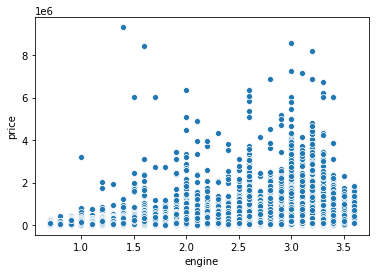

In [28]:
sns.scatterplot(x="engine", y="price", data=df)

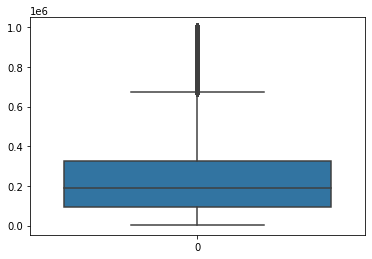

In [337]:
sns.boxplot(data=df.loc[df['price'] < 1000000, 'price'])

In [249]:
df.loc[df['price'] > 3000000, 'price'] = None

In [159]:
df['price'].max()

500000.0

In [221]:
df.loc[df['price'] > 1000000, ['brend', 'model']]

,brend,model
30,porsche,panamera
128,audi,q7
129,mercedes-benz,NaN
148,porsche,911
202,mercedes-benz,NaN
...,...,...
145841,mercedes-benz,NaN
145878,audi,NaN
145910,mercedes-benz,NaN
145919,mercedes-benz,NaN


In [279]:
df.loc[df['price'] > 7000000, 'brend'].value_counts()

porsche          5
mercedes-benz    5
fiat             3
lexus            3
opel             1
chrysler         1
volkswagen       1
ford             1
lamborghini      1
honda            1
infinity         0
jeep             0
jaguar           0
isuzu            0
audi             0
bmw              0
hyundai          0
hummer           0
chevrolet        0
bentley          0
dodge            0
citroen          0
kia              0
volvo            0
lancia           0
lotus            0
toyota           0
tesla            0
suzuki           0
subaru           0
smart            0
skoda            0
seat             0
rover            0
renault          0
peugeot          0
nissan           0
mitsubishi       0
mini             0
mazda            0
maserati         0
alfa-romeo       0
Name: brend, dtype: int64

In [301]:
df.loc[df['price'] > 5000000, ['brend','model', 'price', 'year', 'engine', 'mileage']].loc[df['brend'] == 'lamborghini']

,brend,model,price,year,engine,mileage
1950,lamborghini,aventador,6020200,2015.0,2960.0,2280.00
6062,lamborghini,NaN,6884800,2009.0,3092.0,37686.50
44798,lamborghini,aventador,6366000,2015.0,2960.0,0.95
45461,lamborghini,aventador,5347500,2011.0,3068.0,6175.00
49256,lamborghini,NaN,5166100,NaN,3028.0,12825.00
56413,lamborghini,aventador,5074900,2013.0,2967.0,3895.00
56597,lamborghini,aventador,6367600,2014.0,2960.0,14839.00
90606,lamborghini,aventador,5859800,2014.0,2972.0,20710.00
102446,lamborghini,aventador,6064700,2015.0,2960.0,1738.50
106501,lamborghini,NaN,13380600,2014.0,2960.0,95.00


In [342]:
df = pd.read_csv('data_test.csv')

In [300]:
df.head()

,Unnamed: 0,Марка,Модель,Год выпуска,Рабочий объем,Мощность двигателя,Тип топлива,Трансмиссия,Количество мест,Количество дверей,Пробег
0,146012,opel,astra,1999,1796.0,85.0,бензин,ручной,5.0,4.0,191900.00
1,146013,bmw,NaN,1979,3188.0,147.0,бензин,ручной,4.0,2.0,67071.90
2,146014,peugeot,307,2006,1587.0,80.0,NaN,авто,5.0,5.0,162450.00
3,146015,opel,corsa,2015,1398.0,66.0,NaN,ручной,5.0,5.0,27721.95
4,146016,skoda,octavia,2015,1798.0,10.0,бензин,ручной,5.0,NaN,9.50


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74016 entries, 0 to 74015
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          74016 non-null  int64  
 1   Марка               74016 non-null  object 
 2   Модель              56035 non-null  object 
 3   Год выпуска         74016 non-null  int64  
 4   Рабочий объем       67903 non-null  float64
 5   Мощность двигателя  74016 non-null  float64
 6   Тип топлива         28127 non-null  object 
 7   Трансмиссия         74016 non-null  object 
 8   Количество мест     62084 non-null  float64
 9   Количество дверей   68610 non-null  float64
 10  Пробег              74016 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 6.2+ MB


In [617]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47212 entries, 20775 to 76644
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   brend        47212 non-null  category
 1   model        47212 non-null  category
 2   year         47212 non-null  float64 
 3   engine       47212 non-null  float64 
 4   hp           47212 non-null  float64 
 5   transmisson  47212 non-null  category
 6   seats        47212 non-null  float64 
 7   door         47212 non-null  float64 
 8   mileage      47212 non-null  float64 
dtypes: category(3), float64(6)
memory usage: 2.7 MB


In [346]:
X_test_engine = df.loc[df['engine'].isnull(), df.drop('engine',axis=1).columns]

X_train_engine = df.loc[df['engine'].isnull() == False, df.columns]

y_train_engine = df.loc[df['engine'].isnull() == False, ['engine']]

In [347]:
df['year'] = df['year'].fillna(df['year'].median())

In [348]:
df['hp'] = df['hp'].fillna(df['hp'].median())

In [352]:
predictions = model_LGBM.predict(df)

In [353]:
predictions

array([ 17247.12893455, 361795.10866261,  69738.95180011, ...,
       238952.5894738 ,  88424.57257581, 341368.86327549])

In [354]:
daa = pd.read_csv('sample_submission.csv')

In [355]:
daa['Price'] = predictions

In [356]:
daa

,Id,Price
0,146012,17247.128935
1,146013,361795.108663
2,146014,69738.951800
3,146015,205617.840986
4,146016,310946.917443
...,...,...
74011,220023,894358.953641
74012,220024,130724.196278
74013,220025,238952.589474
74014,220026,88424.572576


In [357]:
daa = daa.set_index('Id')

In [358]:
pd.DataFrame(daa).to_csv('sample_submission.csv')

In [ ]:
0.45709
0.46290

In [ ]:
X_train, X_test, y_train, y_test

In [7]:
X_train

,brend,model,year,engine,hp,transmisson,seats,door,mileage
22217,toyota,avensis,6.0,2231.0,110.0,авто,5.0,4.0,103090.20
55767,porsche,911,15.0,3387.0,221.0,ручной,4.0,2.0,182400.00
5226,bmw,NaN,4.0,2996.0,160.0,ручной,4.0,2.0,51220.20
7783,mercedes-benz,NaN,2.0,1800.0,80.0,ручной,5.0,5.0,53200.00
96570,audi,sq5,0.0,2967.0,230.0,авто,5.0,4.0,12350.00
...,...,...,...,...,...,...,...,...,...
110268,ford,focus,2.0,1560.0,70.0,ручной,5.0,5.0,81700.00
119879,opel,astra,10.0,1364.0,66.0,ручной,5.0,3.0,100130.00
103694,audi,tt,15.0,1781.0,132.0,ручной,2.0,2.0,114000.00
131932,skoda,octavia,12.0,1900.0,74.0,ручной,5.0,5.0,204733.55


In [8]:
X_test

,brend,model,year,engine,hp,transmisson,seats,door,mileage
97938,subaru,forester,5.0,1998.0,108.0,ручной,5.0,5.0,108300.00
74762,mercedes-benz,NaN,6.0,2148.0,100.0,авто,5.0,4.0,247760.00
43874,volkswagen,touran,8.0,1896.0,77.0,ручной,5.0,5.0,146911.80
4727,ford,focus,9.0,1999.0,107.0,ручной,5.0,4.0,50615.05
36556,toyota,aygo,1.0,998.0,50.0,ручной,4.0,5.0,37050.00
...,...,...,...,...,...,...,...,...,...
72841,seat,leon,1.0,1968.0,110.0,ручной,5.0,5.0,17917.00
27971,kia,sephia,18.0,1498.0,59.0,ручной,5.0,4.0,89300.00
66312,fiat,panda,7.0,1242.0,44.0,ручной,4.0,4.0,76950.00
75360,mercedes-benz,NaN,4.0,1991.0,80.0,авто,5.0,4.0,121041.40
